In [1]:
# import all libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1)
import os
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb # Needs pip install lightgbm
%matplotlib inline

In [2]:
file_name = "training.csv"
df = pd.read_csv(file_name, index_col='RefId')
print('Percentage of Negative class is {} %'.format(round(df['IsBadBuy'].value_counts()[0]/len(df) * 100,3)))
print('Percentage of Positive class is {} %'.format(round(df['IsBadBuy'].value_counts()[1]/len(df) * 100,3)))

Percentage of Negative class is 87.701 %
Percentage of Positive class is 12.299 %


In [3]:
def find_bad_columns_function(dataframe):
    ''' Returns: 4 lists containing those features that have nulls, blanks, constant values throughout and 
    those features that are duplicate of other features'''
    ###### Finding Null Values
    null_col_list = dataframe.columns[dataframe.isna().any()].tolist()
    print('Identified {} features with atleast one null'.format(len(null_col_list)))

    ###### Finding Blank Spaces in the object column
    # Non-obvious nulls such as blanks: The line items where there are spaces 
    blank_space_col_list = []
    object_columns = dataframe.select_dtypes(include=['object']).columns
    for col in object_columns:
    #   print(col, sum(dataframe[col]==' '))
        if sum(dataframe[col]==' '):
            blank_space_col_list.append(col)
    print('Identified {} features with atleast one blank space'.format(len(blank_space_col_list)))
    
    ####### Finding Quasi Constant/Constant Value in numerical columns
    # Lets remove the variables that have more than 99% of their values as the same 
    # ie their standard deviation is less than 1 %
    
    numeric_df = dataframe._get_numeric_data()
    constant_numeric_col_list = [col for col in numeric_df.columns if numeric_df[col].std()<0.01]
    print('Identified {} numeric features that have quasi-constant values'.format(len(constant_numeric_col_list)))
    
    # We didnt use the following code snippet for the above because if you have closely varying float values
    # then the below wont pick it up
    
    ###### Finding Quasi Constant/Constant non_numeric value
    constant_non_numeric_col_list = []
    # Find the columns that are not in numeric_df
    non_numeric_col_set = set(dataframe.columns) - set(numeric_df.columns)   
    for col in non_numeric_col_set:
        categorical_mode_value = (dataframe[col].mode().values)[0]
        fractional_presence = sum(dataframe[col]==categorical_mode_value)/len(dataframe) 
        if fractional_presence > 0.99:
            constant_non_numeric_col_list.append(col)
            
    print('Identified {} non-numeric features that have quasi-constant values'.format(len(constant_non_numeric_col_list)))
    
    return null_col_list, blank_space_col_list, constant_numeric_col_list, constant_non_numeric_col_list 


In [4]:
null_col_list, blank_space_col_list, constant_numeric_col_list,\
constant_non_numeric_col_list  = find_bad_columns_function(df)

Identified 19 features with atleast one null
Identified 0 features with atleast one blank space
Identified 0 numeric features that have quasi-constant values
Identified 0 non-numeric features that have quasi-constant values


In [5]:
"""
# In this dataset, we dont have any duplicated columns or those which have near-constant values
# But if they do show up, you should go ahead and delete them to reduce overfitting

print('Before dropping irrelevant features and duplicated columns,')
print('{} number of columns were present'.format(len(df.columns)))

for drop_column_list in [constant_numeric_col_list, constant_non_numeric_col_list]:
    df.drop(drop_column_list, axis=1, inplace=True)

print('After dropping the above, ')
print('{} number of columns are present'.format(len(df.columns)))

# No need to change this code because we are always going to drop these 3 types of columns
"""

"\n# In this dataset, we dont have any duplicated columns or those which have near-constant values\n# But if they do show up, you should go ahead and delete them to reduce overfitting\n\nprint('Before dropping irrelevant features and duplicated columns,')\nprint('{} number of columns were present'.format(len(df.columns)))\n\nfor drop_column_list in [constant_numeric_col_list, constant_non_numeric_col_list]:\n    df.drop(drop_column_list, axis=1, inplace=True)\n\nprint('After dropping the above, ')\nprint('{} number of columns are present'.format(len(df.columns)))\n\n# No need to change this code because we are always going to drop these 3 types of columns\n"

In [5]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
IsBadBuy,1,-0.158886,0.167164,-0.0446196,0.0825604,-0.109252,-0.102954,-0.0874184,-0.0836651,-0.109112,-0.10402,-0.103914,-0.100245,-0.0614884,0.00579642,-0.0999115,-0.0036975,0.0523193
VehYear,-0.158886,1,-0.957957,0.25966,-0.283719,0.581146,0.532927,0.581191,0.53923,0.59082,0.548426,0.59849,0.558669,0.280791,0.0682756,0.349965,0.0573802,-0.268696
VehicleAge,0.167164,-0.957957,1,-0.250801,0.319794,-0.56569,-0.51881,-0.460854,-0.426382,-0.575607,-0.532505,-0.504062,-0.469359,-0.268269,-0.0748569,-0.312329,-0.0247714,0.25931
WheelTypeID,-0.0446196,0.25966,-0.250801,1,-0.213558,-0.0954708,-0.129597,-0.0727003,-0.102019,-0.088597,-0.121211,-0.0744198,-0.102488,0.187199,0.00790108,-0.162826,-0.00674691,-0.132798
VehOdo,0.0825604,-0.283719,0.319794,-0.213558,1,-0.0170218,0.0246171,0.0313058,0.0631649,-0.0285678,0.0121071,0.0158112,0.0480048,-0.288456,-0.0530415,-0.0620085,0.0295558,0.411718
MMRAcquisitionAuctionAveragePrice,-0.109252,0.581146,-0.56569,-0.0954708,-0.0170218,1,0.990347,0.910391,0.910187,0.937817,0.932492,0.871755,0.871042,0.107734,0.0456944,0.78984,0.038818,-0.0504169
MMRAcquisitionAuctionCleanPrice,-0.102954,0.532927,-0.51881,-0.129597,0.0246171,0.990347,1,0.902718,0.918242,0.92361,0.932114,0.860716,0.871203,0.0625025,0.0406752,0.781516,0.0386673,-0.0206443
MMRAcquisitionRetailAveragePrice,-0.0874184,0.581191,-0.460854,-0.0727003,0.0313058,0.910391,0.902718,1,0.990201,0.851647,0.849407,0.913108,0.906054,0.107516,0.0354886,0.746126,0.0806275,-0.053444
MMRAcquisitonRetailCleanPrice,-0.0836651,0.53923,-0.426382,-0.102019,0.0631649,0.910187,0.918242,0.990201,1,0.846914,0.855689,0.903188,0.90681,0.0696759,0.0312839,0.744966,0.0776697,-0.0269328
MMRCurrentAuctionAveragePrice,-0.109112,0.59082,-0.575607,-0.088597,-0.0285678,0.937817,0.92361,0.851647,0.846914,1,0.990329,0.915073,0.912231,0.111363,0.0489654,0.778738,0.0398758,-0.056798


In [6]:
print(" Shape of original data before: ", df.shape)

df = df.drop(['MMRAcquisitionAuctionCleanPrice','MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice',
              'MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice','MMRCurrentRetailAveragePrice',
              ], axis = 1)
print(" Shape of data after dropping correlated cols now is: ", df.shape)


# VehYear and VehicleAge are the same, hence removing the VehYear Col 
# WheelTypeID and WheelType are the same, hence removing WheelType Col

df = df.drop(['VehYear','WheelType'], axis = 1)
print(" Shape of data after dropping VehYear & WheelType set now is: ", df.shape)

# Field "PRIMEUNIT" & "AUCGUART" has only 3419 entry, rest all NULL values, It is as good as not haveing  
# therse fields So we can drop these two coloumns 
df = df.drop(['PRIMEUNIT','AUCGUART'], axis = 1)
print(" Shape of data set after droping PRIMEUNIT & AUCGUART now is: ", df.shape)

 Shape of original data before:  (72983, 33)
 Shape of data after dropping correlated cols now is:  (72983, 27)
 Shape of data after dropping VehYear & WheelType set now is:  (72983, 25)
 Shape of data set after droping PRIMEUNIT & AUCGUART now is:  (72983, 23)


In [ ]:

#miss_col = df.columns[df.isna().any()].tolist()
#for col in miss_col:
#    print(col)
#    print(df[col].describe())
#    print("---"*30)
#"""

In [ ]:
#df.isnull().sum()

In [ ]:

"""
Before we do any imputation or transformation, we should split it. 
This ensures that
we are fitting with training data and transforming on the test data.
"""
"""
X = df.drop("IsBadBuy", axis=1)
y = df["IsBadBuy"]

# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Note optionally convert the pandas dataframe into a numpy array using to_numpy if you have a big data
# and want to model faster. Otherwise it doesnt matter which data structure you use

"""

In [7]:
#filling the missing col with mode 
cl = df.columns[df.isna().any()].tolist()
for col in cl:
    df[col] = df[col].fillna(df[col].mode()[0])

In [8]:
df.isnull().sum()

IsBadBuy                             0
PurchDate                            0
Auction                              0
VehicleAge                           0
Make                                 0
Model                                0
Trim                                 0
SubModel                             0
Color                                0
Transmission                         0
WheelTypeID                          0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
MMRCurrentRetailCleanPrice           0
BYRNO                                0
VNZIP1                               0
VNST                                 0
VehBCost                             0
IsOnlineSale                         0
WarrantyCost                         0
dtype: int64

In [ ]:
#df.info()

In [ ]:
"""
X = df.drop("IsBadBuy", axis=1)
y = df["IsBadBuy"]

# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
"""

In [ ]:
"""
# This step is needed if you want to convert all categorical columns to ordinal encoded numbers
# Works only with tree-based algorithms but not for linear models or neural nets

from feature_engine.categorical_encoders import RareLabelCategoricalEncoder

# Filter the above object columns based on the object data type
#object_col_list = list(X_train.select_dtypes(include=['object']).columns)
object_col_list = ['Make', 'Model', 'Trim', 'SubModel','Color',
                   'Nationality','Size','VNST']
# First select the features with greater than 2 levels
cat_series = X_train[object_col_list].nunique()
non_binary_cat_col_list = list(cat_series[cat_series>2].index)

# This takes of the situation where the % occurrence is relatively high in the levels
# ie where none of the levels are lower than 5% cutoff
for col in non_binary_cat_col_list:

    print(col)
    
    level_perc_dict = (X_train.groupby(col)[col].count()/len(X_train)).to_dict()
    
    # Get the level with the lowest percentage of occurrence
    lowest_occurrence_level = min(level_perc_dict, key=level_perc_dict.get)
    
#     print(lowest_occurrence_level)
    
    # Replace the lowest level of the train with rare
    X_train[col] = np.where(X_train[col].isin([lowest_occurrence_level]), 'Rare', X_train[col])
    
    # Repeat for the test (notice how the lowest level is from the train)
    X_test[col] = np.where(X_test[col].isin([lowest_occurrence_level]), 'Rare', X_test[col])
    
# If I had just used the RareLabelCategoricalEncoder, then I would be screwed when Test contains levels
# not seen in the train set for those features that are relatively well balanced and above 5% in train

#### This takes care of those levels that are genuinely too rare

# Instantiate the encoder from the Feature Engine
rare_encoder_obj = RareLabelCategoricalEncoder(tol=0.05, 
                                               n_categories=3, variables=non_binary_cat_col_list)


rare_encoder_obj.fit(X_train)

# Transform both the train and test objects
X_train = rare_encoder_obj.transform(X_train)
X_test = rare_encoder_obj.transform(X_test)
"""

In [ ]:
"""
# This method of Label Encoding assumes that we are using Tree-based models later.
# Because the numbers assigned to the levels are meaningless

from sklearn.preprocessing import LabelEncoder
object_col_list = list(X_train.select_dtypes(include=['object']).columns)
# Iterate through the object columns and convert them one by one into a numerical column
for col in object_col_list:
    
    print(col)
    # Instantiate a labelencoder object
    labelencoder = LabelEncoder()
    
    # and then do the fit transform on the Train set
    X_train[col] = labelencoder.fit_transform(X_train[col])
    
    # In production, you would export the above as a pickled object and re-import it back in
    # Transform the test set
    X_test[col] = labelencoder.transform(X_test[col])
    
X_train.head()
# Notice how the word descriptions have been converted to numbers
"""

In [ ]:
"""
from sklearn.preprocessing import LabelEncoder

# Instantiate a labelencoder object
labelencoder = LabelEncoder()

# and then do the fit transform on the Train set
y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

# convert the numpy arrays back into pandas 

y_train = pd.DataFrame(y_train, columns=['Churn'])
y_test = pd.DataFrame(y_test, columns=['Churn'])
"""

In [9]:
# This step is needed if you want to convert all categorical columns to ordinal encoded numbers
# Filter the above object columns based on the object data type

object_columns = df.select_dtypes(include=['object']).columns
print(df[object_columns].head(), "\n\n")

# This method of Label Encoding assumes that we are using Tree-based models later.

from sklearn.preprocessing import LabelEncoder

# Iterate through the object columns and convert them one by one into a numerical column
for column in object_columns:
    # Instantiate a labelencoder object and then do the fit transform on the data
    labelencoder = LabelEncoder()
    df[column] = labelencoder.fit_transform(df[column])
    
print(df.head())

       PurchDate Auction   Make                Model Trim           SubModel  \
RefId                                                                          
1      12/7/2009   ADESA  MAZDA               MAZDA3    i         4D SEDAN I   
2      12/7/2009   ADESA  DODGE  1500 RAM PICKUP 2WD   ST  QUAD CAB 4.7L SLT   
3      12/7/2009   ADESA  DODGE           STRATUS V6  SXT   4D SEDAN SXT FFV   
4      12/7/2009   ADESA  DODGE                 NEON  SXT           4D SEDAN   
5      12/7/2009   ADESA   FORD                FOCUS  ZX3       2D COUPE ZX3   

        Color Transmission  Nationality         Size TopThreeAmericanName VNST  
RefId                                                                           
1         RED         AUTO  OTHER ASIAN       MEDIUM                OTHER   FL  
2       WHITE         AUTO     AMERICAN  LARGE TRUCK             CHRYSLER   FL  
3      MAROON         AUTO     AMERICAN       MEDIUM             CHRYSLER   FL  
4      SILVER         AUTO     AME

In [10]:
df.shape

(72983, 23)

In [11]:
Goodbuy = df[df['IsBadBuy']==0]
Badbuy = df[df['IsBadBuy']==1]
print(Goodbuy.shape, Badbuy.shape)

(64007, 23) (8976, 23)


In [12]:
X = df.drop('IsBadBuy', axis=1)
y = df['IsBadBuy']

# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("The length of train:{}| positives in y(train):{}".format(len(X_train), sum(y_train)))
print("The length of test:{}| positives in y(test):{}".format(len(X_test), sum(y_test)))

The length of train:58386| positives in y(train):7229
The length of test:14597| positives in y(test):1747


### UnderSampling

In [13]:
from imblearn.under_sampling import NearMiss

Using TensorFlow backend.


In [14]:
random_state = 42

In [15]:
nm = NearMiss()
X_US,y_US=nm.fit_sample(X_train,y_train)

In [16]:
X_US.shape,y_US.shape

((14458, 22), (14458,))

In [17]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_US)))

Original dataset shape Counter({0: 64007, 1: 8976})
Resampled dataset shape Counter({0: 7229, 1: 7229})


### OverSampling

##### SMOTETomek 

In [18]:
Goodbuy = df[df['IsBadBuy']==0]
Badbuy = df[df['IsBadBuy']==1]
print(Goodbuy.shape, Badbuy.shape)

(64007, 23) (8976, 23)


In [19]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

In [20]:
# Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42)
X_SMK,y_SMK=smk.fit_sample(X,y)

In [21]:
X_SMK.shape,y_SMK.shape

((126408, 22), (126408,))

In [22]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_SMK)))

Original dataset shape Counter({0: 64007, 1: 8976})
Resampled dataset shape Counter({0: 63204, 1: 63204})


#### Random OverSampling

In [23]:
## RandomOverSampler to handle imbalanced data
from imblearn.over_sampling import RandomOverSampler

In [24]:
ratio = 0.5
os =  RandomOverSampler(ratio)
X_ROS, y_ROS = os.fit_sample(X, y)
X_ROS.shape,y_ROS.shape

((96010, 22), (96010,))

In [25]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_ROS)))

Original dataset shape Counter({0: 64007, 1: 8976})
Resampled dataset shape Counter({0: 64007, 1: 32003})


### To Use

In [26]:
X_train1 = X_US
y_train1 = y_US

In [27]:
X_train2  = X_SMK 
y_train2  = y_SMK

In [28]:
X_train3 = X_ROS  
y_train3 = y_ROS  

## week 4 

In [ ]:
"""
# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tu, y_tu, test_size=0.2, random_state=42)

print("The length of train:{}| positives in y(train):{}".format(len(X_train), sum(y_train)))
print("The length of test:{}| positives in y(test):{}".format(len(X_test), sum(y_test)))
"""

In [29]:
import matplotlib.pyplot as plt

In [ ]:
#import plot_learning_curve

In [36]:
from sklearn.ensemble import RandomForestClassifier
# This is for the hyperparam tuning and KFold CV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit
# Classification metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.
    title : string
        Title for the chart.
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.
        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    # call the sklearn learning_curve function 
    # that returns an array of train sizes and associated train/test scores
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    import matplotlib.pyplot as plt
    ############### Plotting 
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    
    plt.grid()

    # Create a fuzzy margin around the main trend line with outerbounds defined by +/- std deviation
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\owner\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

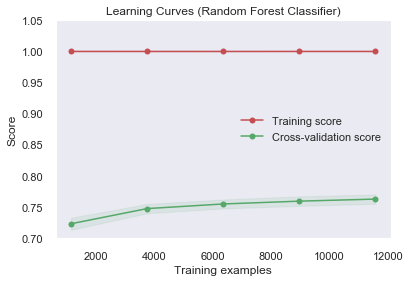

In [37]:
title = "Learning Curves (Random Forest Classifier)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X_train1, y_train1, ylim=(0.7, 1.05), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from 'C:\\Users\\owner\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

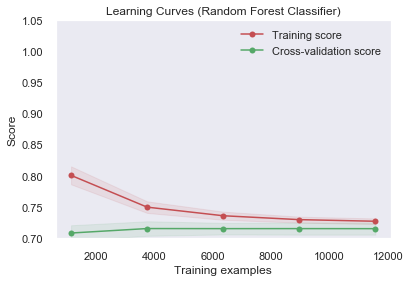

In [39]:
title = "Learning Curves (Random Forest Classifier)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestClassifier(max_depth=5)
plot_learning_curve(estimator, title, X_train1, y_train1, ylim=(0.7, 1.05), cv=cv, n_jobs=4)

# Just using 2 hyperparams resulted in a significant improvement in the variance by reducing the gap


In [40]:
# Maximum number of levels in tree
max_depth = [3, 4, 5, 6, 7]
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 6, 7]
class_weight = ['balanced', {0:1,1:2}, {0:1,1:3}, {0:1,1:4}, {0:1,1:5}]
# Create the grid for the random search. 
rf_params = {'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'class_weight':class_weight}

In [ ]:
"""
# Maximum number of levels in tree
max_depth = [3, 4]

# Minimum number of samples required to split a node
min_samples_split = [2, 3]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

class_weight = ['balanced', {0:1,1:2},  {0:1,1:5}]

# Create the grid for the random search. 
rf_params = {'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'class_weight':class_weight}
"""

In [41]:
def metrics_store_function(optimised_model, cv_fold_X_val, cv_fold_y_val):
    from collections import Counter
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
    classification_metrics_dict = Counter()
    # Predict on the validation folds that have NOT been upsampled
    val_pred = optimised_model.predict(cv_fold_X_val)
    classification_metrics_dict['accuracy'] = optimised_model.score(cv_fold_X_val, cv_fold_y_val)
    classification_metrics_dict['precision'] = precision_score(cv_fold_y_val, val_pred)
    classification_metrics_dict['recall'] = recall_score(cv_fold_y_val, val_pred)
    classification_metrics_dict['f1'] = f1_score(cv_fold_y_val, val_pred)
    classification_metrics_dict['roc_auc'] = roc_auc_score(cv_fold_y_val, val_pred)

    return classification_metrics_dict

In [42]:
def hyper_param_search_function(X_train, y_train, hyper_param_space, 
                                classifier_type = RandomForestClassifier, n_iter = 30,
                                 search_method = 'random_search'):
    '''
    Args: training data + hyperparam search space according to the sklearn classifier being passed;
    
    The search_method specifies whether its a RandomSearchCV or a GridSearchCV being passed inside
    
    '''
    # This is to store the best_params and the roc from each fold 
    hyperparam_results = Counter()

    cv_fold_X_train, cv_fold_X_val, cv_fold_y_train, cv_fold_y_val = train_test_split(X_train, y_train, 
                                                        test_size=0.2, random_state=42, stratify=y_train)

    # Instantiate a classifier (eg:RandomForest) object along with the hyperparam range
    if search_method == 'random_search':
        search_object = RandomizedSearchCV(classifier_type(), 
                                  hyper_param_space, cv = 5, n_iter = n_iter,
                                  verbose=4, random_state=42, n_jobs = -1)

    elif search_method == 'grid_search':
        search_object = GridSearchCV(classifier_type(), 
                                  hyper_param_space, cv = 5, 
                                  verbose=4, n_jobs = -1)

    # I have deliberately used the if-else statement because 
    # there are slight syntactical differences between the parameter inputs for Random vs Grid Search

    # Actually fitting the model on the subset of the training data
    model = search_object.fit(cv_fold_X_train, cv_fold_y_train)

    # We really need just 2 sets of data: the best hyperparam combo and validation performance estimate
    hyperparam_results['best_params'] = model.best_params_
    
    # Get the model with the best combination of hyperparams, use it to predict on validation fold
    optimised_model = model.best_estimator_

    # .... and store all the relevant classification metrics
    classification_metrics_dict = metrics_store_function(optimised_model, cv_fold_X_val, cv_fold_y_val)
  
    hyperparam_results['classification_metrics'] = classification_metrics_dict

    ######### Pretty print
    print('---' * 45)
    print('')

    print("Accuracy: {}".format(round(classification_metrics_dict['accuracy'],4)))
    print("Precision: {}".format(round(classification_metrics_dict['precision']),4))
    print("Recall: {}".format(round(classification_metrics_dict['recall'],4)))
    print("F1: {}".format(round(classification_metrics_dict['f1'],4)))
    print("AUC ROC: {}".format(round(classification_metrics_dict['roc_auc'],4)))

    print('---' * 45)
    
    return hyperparam_results

In [43]:
classifier_type = RandomForestClassifier
search_method = 'grid_search'
hyperparam_results = hyper_param_search_function(X_train, y_train, rf_params, 
                                    classifier_type = classifier_type, search_method = search_method)


Fitting 5 folds for each of 700 candidates, totalling 3500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 49.4min
[Parallel(n_jobs=-1)]: Done 2957 tasks      | elapsed: 60.7min
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed: 72.6min finished


---------------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.8765
Precision: 1.0
Recall: 0.0028
F1: 0.0055
AUC ROC: 0.5014
---------------------------------------------------------------------------------------------------------------------------------------


In [44]:
hyperparam_results

Counter({'best_params': {'class_weight': {0: 1, 1: 2},
          'max_depth': 5,
          'min_samples_leaf': 2,
          'min_samples_split': 5},
         'classification_metrics': Counter({'accuracy': 0.8765199520465833,
                  'precision': 1.0,
                  'recall': 0.0027662517289073307,
                  'f1': 0.005517241379310345,
                  'roc_auc': 0.5013831258644537})})

In [45]:
from sklearn.ensemble import RandomForestClassifier

# # Get the tuned hyperparam from GridSearch results
max_depth = hyperparam_results['best_params']['max_depth']
min_samples_split = hyperparam_results['best_params']['min_samples_split']
min_samples_leaf = hyperparam_results['best_params']['min_samples_leaf']
class_weight = hyperparam_results['best_params']['class_weight']

# Instantiate the classifier with the above hyperparams
classifier = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    class_weight=class_weight, n_jobs = -1, random_state=42)

classifier.fit(X_train1, y_train1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [46]:
"""
from sklearn.ensemble import RandomForestClassifier

# Initialize a classifier object with default params
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
"""
# Make predictions using both train and test set
rf_train_pred = classifier.predict(X_train1)
rf_test_pred = classifier.predict(X_test)

training_score = classifier.score(X_train1, y_train1)
test_score = classifier.score(X_test, y_test)

print("Has a training accuracy of {} % ".format(round(training_score.mean(), 5) * 100))
print("Has a test accuracy of {} % ".format(round(test_score.mean(), 5) * 100))

# The accuracy score on its own is less useful for classification. Need to check the confusion matrix
# Notice how severe the overfitting is

Has a training accuracy of 59.386 % 
Has a test accuracy of 16.414 % 


In [47]:
from sklearn.metrics import classification_report
print("classification_report\n", classification_report(y_train1, rf_train_pred), "\n")

print("classification_report\n", classification_report(y_test, rf_test_pred), "\n")
# As can be seen in the report below, the F1 score can be improved

classification_report
               precision    recall  f1-score   support

           0       0.92      0.21      0.34      7229
           1       0.55      0.98      0.71      7229

    accuracy                           0.59     14458
   macro avg       0.74      0.59      0.52     14458
weighted avg       0.74      0.59      0.52     14458
 

classification_report
               precision    recall  f1-score   support

           0       0.95      0.05      0.10     12850
           1       0.12      0.98      0.22      1747

    accuracy                           0.16     14597
   macro avg       0.54      0.52      0.16     14597
weighted avg       0.85      0.16      0.11     14597
 



In [48]:
import itertools
# This is from sklearn's example page 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  683 12167]
 [   34  1713]]


Of the 14597 items in the Test set,
The model correctly predicts 1713 true positives while missing out on 34 false negatives
It also picks up 12167 false positives


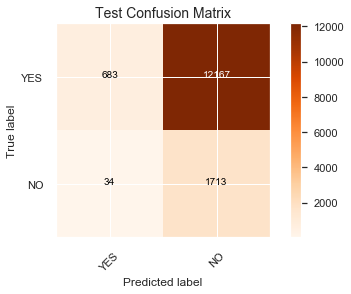

In [50]:
import matplotlib.pyplot as plt
labels = [ 'YES', 'NO']
from sklearn.metrics import confusion_matrix

# Call the function above for the....
# training data 
confusion_matrix_train_object = confusion_matrix(y_train1, rf_train_pred)

# and
# test data
confusion_matrix_test_object = confusion_matrix(y_test, rf_test_pred)


#fig = plt.figure(figsize=(8,4))
plot_confusion_matrix(confusion_matrix_test_object, labels, title="Test Confusion Matrix", 
                      cmap=plt.cm.Oranges)

print('\n')
tn, fp, fn, tp = confusion_matrix_test_object.ravel()
print('Of the {} items in the Test set,'.format(len(y_test)))
print('The model correctly predicts {} true positives while missing out on {} false negatives'.format(
tp, fn))

print('It also picks up {} false positives'.format(fp))

# FP of  of  is pretty bad. 
# FN of  of  is also pretty bad. 

In [51]:
from sklearn.metrics import roc_auc_score
print("Test:", roc_auc_score(y_test, rf_test_pred))
print("Train:", roc_auc_score(y_train1, rf_train_pred))

Test: 0.5168449081137426
Train: 0.5938580716558306
